In [2]:
from Bio.PDB import *
import freesasa
import os
def parse_input_data_to_pdb_format(file_path):
    """
    Reads input data from a file, parses it, and converts it to a list of tuples with PDB file names and residue numbers.
    
    Args:
    file_path (str): Path to the file containing the input data.
    
    Returns:
    list of tuples: Each tuple contains a PDB file name and a list of residue numbers.
    """
    pdb_files_and_residues = []

    with open(file_path, 'r') as file:
        # skip header
        file.readline()
        lines = file.readlines()


    for line in lines:
        parts = line.strip().split()
        if len(parts) < 3:
            continue  # Skip lines that don't have enough data

        protein_name = parts[0]
        pdb_file = f"{protein_name}.pdb"

        # Extract residue numbers from the Hotspot_Info column
        residues = []
        hotspot_info = parts[2].split('|')
        for info in hotspot_info:
            _, residue_info = info.split('@', 1)
            for res in residue_info.split(';'):
                model, chain, residue_number = res.split(':')
                residues.append(int(residue_number))

        pdb_files_and_residues.append((pdb_file, residues))

    return pdb_files_and_residues

max_sasa_values = {
    'ALA': 129.0,
    'ARG': 274.0,
    'ASN': 195.0,
    'ASP': 193.0,
    'CYS': 167.0,
    'GLN': 225.0,
    'GLU': 223.0,
    'GLY': 104.0,
    'HIS': 224.0,
    'ILE': 197.0,
    'LEU': 201.0,
    'LYS': 236.0,
    'MET': 224.0,
    'PHE': 240.0,
    'PRO': 159.0,
    'SER': 155.0,
    'THR': 172.0,
    'TRP': 285.0,
    'TYR': 263.0,
    'VAL': 174.0
}

def analyze_residues(pdb_path, pdb_file, residue_numbers, output_file, write_header=True):
    # Load the structure
    parser = PDBParser()
    protein_path = os.path.join(pdb_path, pdb_file)
    try:
        structure = parser.get_structure("protein", protein_path)
    except FileNotFoundError:
        #print(f"Could not find {protein_path}. Skipping...")
        return

    # Use FreeSASA
    structure_sasa = freesasa.Structure(protein_path)
    result = freesasa.calc(structure_sasa)
    sasa_per_residue = result.residueAreas()

    with open(output_file, "a") as file:  # Append mode

        for model in structure:
            for chain in model:
                for residue in chain:
                    residue_id = residue.get_full_id()[3][1]
                    if residue_id in residue_numbers:
                        # Check if residue ID is in the results
                        if str(residue_id) not in sasa_per_residue[chain.id].keys():
                            print(residue_id)
                            #print(sasa_per_residue[chain.id].keys())
                            continue


                        # Get SASA for the residue
                        sasa = sasa_per_residue[chain.id][str(residue_id)].total
                        sasa_percent = sasa / max_sasa_values[residue.resname] * 100
                        solvent_status = "Exposed" if sasa_percent >= 20 else "Buried"  # Adjust threshold as needed

                        # Check for disorder using pLDDT score
                        plddt_score = residue["CA"].get_bfactor() if residue.has_id("CA") else None
                        disorder_status = "Disordered" if plddt_score < 50 else "Ordered"  # Adjust threshold as needed

                        # remove the .pdb extension
                        pdb_name = pdb_file[:-4]

                        # Write data in tab-delimited format
                        file.write(f"{os.path.basename(pdb_name)}\t{residue_id}\t{chain.id}\t{sasa_percent}\t{solvent_status}\t{plddt_score}\t{disorder_status}\n")


# hotmaps result


pdb_path = "/Users/elaine/Documents/HotMAPS2/Structures/"

for tumor_type in ["NDD", "CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    print(f"Processing {tumor_type}...")
    hotregions_file = f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_hotregions.txt"
    pdb_files_and_residues = parse_input_data_to_pdb_format(hotregions_file)

    output_file = f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_analysis.tsv"  # Output file

    # write header
    with open(output_file, "w") as file:
        file.write("ProteinID\tResidue\tChain\tSASA%\tSolvent Status\tpLDDT Score\tDisorder Status\n")

    # Process each PDB file and write to the same output file
    for i, (pdb_file, residues) in enumerate(pdb_files_and_residues):
        analyze_residues(pdb_path, pdb_file, residues, output_file, write_header=(i==0))


    print("Analysis complete. Results are in:", output_file)


Processing NDD...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/NDD_analysis.tsv
Processing CNV...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/CNV_analysis.tsv
Processing GI...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/GI_analysis.tsv
Processing BRCA...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/BRCA_analysis.tsv
Processing OV...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/OV_analysis.tsv
Processing PRAD...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/PRAD_analysis.tsv
Processing LUAD...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/LUAD_analysis.tsv
Processing COAD...
Analysis complete. Results are in: /Users/elaine/Documents/HotMAPS2/HM_results/COAD_analysis.tsv


/var/folders/t9/1v5dh1xs26sgvp2lbdy048jw0000gn/T/ipykernel_39842/458918139.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tumor_types, rotation=45, ha="right")
/var/folders/t9/1v5dh1xs26sgvp2lbdy048jw0000gn/T/ipykernel_39842/458918139.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tumor_types, rotation=45, ha="right")


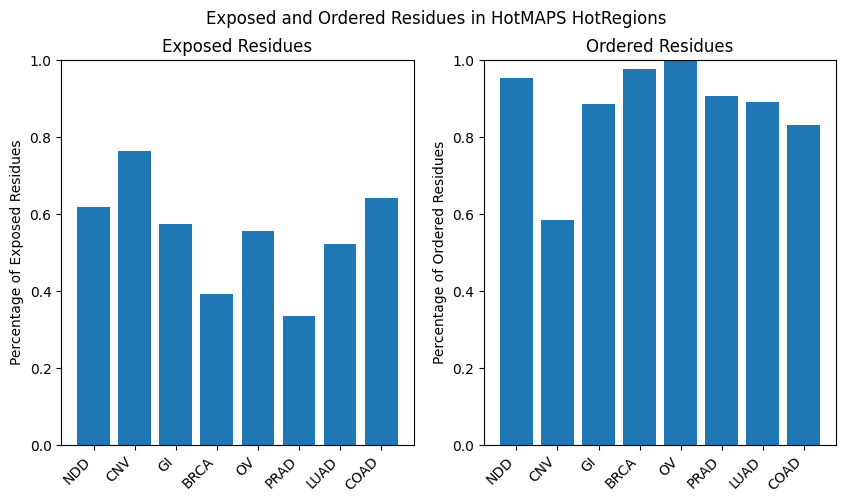

In [5]:
# visualize percentage of exposed residues and ordered residues in each tumor type
import pandas as pd
import matplotlib.pyplot as plt

tumor_types = ["NDD", "CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]
exposed_residues = []
ordered_residues = []
for tumor_type in tumor_types:
    df = pd.read_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_analysis.tsv", sep="\t")
    exposed_residues.append(df["Solvent Status"].value_counts(normalize=True)["Exposed"])
    ordered_residues.append(df["Disorder Status"].value_counts(normalize=True)["Ordered"])


# create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Exposed and Ordered Residues in HotMAPS HotRegions")

# plot exposed residues
ax1.bar(tumor_types, exposed_residues)
ax1.set_title("Exposed Residues")
ax1.set_ylabel("Percentage of Exposed Residues")
ax1.set_ylim(0, 1)

# plot ordered residues
ax2.bar(tumor_types, ordered_residues)
ax2.set_title("Ordered Residues")
ax2.set_ylabel("Percentage of Ordered Residues")
ax2.set_ylim(0, 1)

# x-axis labels
for ax in [ax1, ax2]:
    ax.set_xticklabels(tumor_types, rotation=45, ha="right")

plt.show()



In [18]:
def generate_pymol_script(Tumor, pdb_dir, result_dir, pml_dir):
    def import_hotregions(filename):
        hotregions = {}
        with open(filename, 'r') as file:
            next(file)  # Skip header
            for line in file:
                protein_id, _, hotspot_info = line.strip().split('\t')
                regions = hotspot_info.split('|')
                hotregions_residues = []
                for region in regions:
                    residues = [res.split(':')[2] for res in region.split(';')]
                    hotregions_residues.extend(residues)
                hotregions[protein_id] = hotregions_residues
        return hotregions

    def import_mutation_counts(filename):
        mutation_counts = {}
        with open(filename, 'r') as file:
            for line in file:
                protein_id, _, location, count = line.strip().split('\t')
                residue = location.split(':')[1]
                mutation_counts[(protein_id, residue)] = int(count)
        return mutation_counts

    def get_pvalue_cutoff(filename):
        with open(filename, 'r') as file:
            return float(file.readline().strip().split('\t')[1])


    def import_hotspots(filename):
        hotspots = {}
        with open(filename, 'r') as file:
            next(file)  # Skip header
            for line in file:
                parts = line.strip().split('\t')
                residue = parts[4]
                p_value = float(parts[8])
                hotspots[(np_id, residue)] = p_value
        return hotspots


    hotregions_file = f'{result_dir}/{Tumor}_hotregions.txt'
    hotspots_file = f'{result_dir}/{Tumor}_hotspots_multitestcorrected.txt'
    pvalue_cutoff_file = f'{result_dir}/{Tumor}_significance_level.txt'
    mutation_counts_file = f'{result_dir}/{Tumor}_mutation_counts.txt'

    hotregions = import_hotregions(hotregions_file)
    hotspots = import_hotspots(hotspots_file)
    mutation_counts = import_mutation_counts(mutation_counts_file)
    pvalue_cutoff = get_pvalue_cutoff(pvalue_cutoff_file)

    # Determine min and max mutation counts
    min_count = min(mutation_counts.values())
    max_count = max(mutation_counts.values())

    for protein_id in hotregions:
        pdb_path = f'{pdb_dir}/{protein_id}.pdb'
        script_name = f'{pml_dir}/{Tumor}/{protein_id}.pml'

        with open(script_name, "w+") as file:
            file.write(f'load {pdb_path}\n')
            file.write(f'bg_color white\n')
            file.write(f'show cartoon\n')
            file.write(f'color grey\n')

            # Show side chains for residues in hotregions
            for region in hotregions[protein_id]:
                file.write(f'show spheres, {protein_id} and resi {region}\n')


            # Highlight hotspots
            for (np_id, residue), p_value in hotspots.items():
                if np_id == protein_id and p_value < pvalue_cutoff:
                    count = mutation_counts.get((protein_id, residue), 0)
                    file.write(f'alter {protein_id} and resi {residue}, b={count}\n')

            # Apply gradient coloring based on b-factor (mutation count)
            file.write(f'spectrum b, red_white, {protein_id}, minimum={min_count}, maximum={max_count}\n')


            file.write(f'zoom\n')
            file.write(f'save {Tumor}_{protein_id}.pse\n')
            file.write(f'png {Tumor}_{protein_id}.jpg\n')
            file.write(f'quit\n')

for tumor_type in ["NDD", "CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    print(f"Processing {tumor_type}...")
    pdb_path = pdb_path = "/Users/elaine/Documents/HotMAPS2/Structures/"
    result_dir = "/Users/elaine/Documents/HotMAPS2/HM_results/"
    pml_dir = "/Users/elaine/Documents/HotMAPS2/HM_results/pml/"
    generate_pymol_script(tumor_type, pdb_path, result_dir, "/Users/elaine/Documents/HotMAPS2/HM_results/pml/")

Processing NDD...
Processing CNV...
Processing GI...
Processing BRCA...
Processing OV...
Processing PRAD...
Processing LUAD...
Processing COAD...


# Second analysis


In [54]:
from Bio.PDB import *
import freesasa
import os

# read csv file
def read_multicorrected(multitestcorrected):

    df = pd.read_csv(multitestcorrected, sep="\t")

    # extract protein id and residue number
    protein_id = df["Sequence Ontology Transcript"]
    residue_number = df["Mutation Residue"]
    # make a list of list of row index,  protein id and residue number
    protein_residue = []
    for i in range(len(protein_id)):
        protein_residue.append((protein_id[i], residue_number[i]))

    return df, protein_residue

In [31]:
max_sasa_values = {
    'ALA': 129.0,
    'ARG': 274.0,
    'ASN': 195.0,
    'ASP': 193.0,
    'CYS': 167.0,
    'GLN': 225.0,
    'GLU': 223.0,
    'GLY': 104.0,
    'HIS': 224.0,
    'ILE': 197.0,
    'LEU': 201.0,
    'LYS': 236.0,
    'MET': 224.0,
    'PHE': 240.0,
    'PRO': 159.0,
    'SER': 155.0,
    'THR': 172.0,
    'TRP': 285.0,
    'TYR': 263.0,
    'VAL': 174.0
}
def analyze_residues(pdb_path, protein_residue):
    # Load the structure
    parser = PDBParser()
    pdb_file = f"{protein_residue[0]}.pdb"
    residue_number = int(protein_residue[1])
    protein_path = os.path.join(pdb_path, pdb_file)
    try:
        structure = parser.get_structure("protein", protein_path)
    except FileNotFoundError:
        #print(f"Could not find {protein_path}. Skipping...")
        return

    # Use FreeSASA
    structure_sasa = freesasa.Structure(protein_path)
    result = freesasa.calc(structure_sasa)
    sasa_per_residue = result.residueAreas()

    residue = structure[0]["A"][residue_number]
    

    # get residue id at residue number
    residue_id = residue.get_full_id()[3][1]
    # get residue name
    residue_name = residue.resname

    # Get SASA for the residue
    sasa = sasa_per_residue["A"][str(residue_id)].total
    sasa_percent = sasa / max_sasa_values[residue_name] * 100
    Exposed = True if sasa_percent >= 20 else False  # Adjust threshold as needed

    # Check for disorder using pLDDT score
    plddt_score = residue["CA"].get_bfactor() if residue.has_id("CA") else None
    Ordered = True if plddt_score > 50 else False  # Adjust threshold as needed

    # return average plddt score of the structure
    plddt_structure = 0
    res_count = 0
    for residue in structure.get_residues():
        if residue.has_id("CA"):
            plddt_structure += residue["CA"].get_bfactor()
            res_count += 1
    Plddt_structure = plddt_structure / res_count

    return Exposed, Ordered, Plddt_structure



In [36]:
# get hotregion information from hotregions file for each protein residue pair
def read_hotregion(file_path):
    """
    Reads input data from a file, parses it, and converts it to a list of tuples with PDB file names and residue numbers.
    
    Args:
    file_path (str): Path to the file containing the input data.
    
    Returns:
    list of tuples: Each tuple contains a PDB file name and a list of residue numbers.
    """
    id_hotregions = {}

    with open(file_path, 'r') as file:
        # skip header
        file.readline()
        lines = file.readlines()


    for line in lines:
        parts = line.strip().split()
        if len(parts) < 3:
            continue  # Skip lines that don't have enough data

        protein_name = parts[0]
        
        # Extract residue numbers from the Hotspot_Info column
        hotregions = []
        hotspot_info = parts[2].split('|')
        # put each hotregion into a list
        for region in hotspot_info:
            _, residue_info = region.split('@', 1)
            residues = [res.split(':')[2] for res in residue_info.split(';')]
            hotregions.append(residues)

        id_hotregions[protein_name] = hotregions

    return id_hotregions

In [61]:
def find_hotregion_neighbors(protein_residue, hotregions):
    protein_id = protein_residue[0]
    residue_number = protein_residue[1]
    hotregion_neighbors = []
    if protein_id not in hotregions:
        return hotregion_neighbors
    for hotregion in hotregions[protein_id]:
        if str(residue_number) in hotregion:
            # extract residue number from hotregion
            # exclude residue number of interest
            # make a copy of hotregion
            hotregion = hotregion.copy()
            hotregion.remove(str(residue_number))
            hotregion_neighbors.extend(hotregion)
    return hotregion_neighbors

In [75]:
# find which tumor shares the same hotspot as the given tumor
def find_shared_hotspot(protein_residue, tumor_type, all_hotspots):
    shared_tumor_type = []
    for curr_tumor_type in ["NDD", "CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
        if curr_tumor_type != tumor_type:
            # turn hotspots into a set
            if protein_residue in set(all_hotspots[curr_tumor_type]):
                shared_tumor_type.append(curr_tumor_type)
    return shared_tumor_type

In [119]:
# get actual mutation count of the hotspot
def read_count_file(mutation_count_file):
    '''
    NP_000005	ndd_out	1034:A	1
    NP_000005	ndd_out	1091:A	1
    NP_000005	ndd_out	1102:A	1
    NP_000005	ndd_out	117:A	1
    NP_000005	ndd_out	1201:A	1
    NP_000005	ndd_out	125:A	1
    '''
    # Dictionary to store the data
    data_dict = {}

    # Open the file and read line by line
    with open(mutation_count_file, 'r') as file:
        for line in file:
            # Split the line into parts
            parts = line.strip().split('\t')
            
            # Extract the first and third columns (before the colon in the third column)
            key = (parts[0], int(parts[2].split(':')[0]))

            # Extract the last column for the value
            value = parts[-1]

            # Add to the dictionary
            data_dict[key] = value

    return data_dict

# Annotate Hotspots

In [120]:
import csv
pdb_path = "/Users/elaine/Documents/HotMAPS2/Structures/"

# load all hotspot information beforehand
all_hotspots = {}
all_df = {}
for tumor_type in ["NDD", "CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    multitestcorrected_file = f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_hotspots_multitestcorrected.txt"
    df, protein_residues = read_multicorrected(multitestcorrected_file)
    all_hotspots[tumor_type] = protein_residues
    all_df[tumor_type] = df

    


for tumor_type in ["NDD", "CNV", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    print(f"Processing {tumor_type}...")

    df = all_df[tumor_type]
    protein_residues = all_hotspots[tumor_type]

    hotregions_file = f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_hotregions.txt"
    hotregions = read_hotregion(hotregions_file)

    mutation_count_file = f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_mutation_counts.txt"
    counts = read_count_file(mutation_count_file)


    # get solvent and structure info
    Counts = []
    Exposed = []
    Ordered = []
    Plddt_structure = []
    Hotregion_neighbors = []
    Shared_tumor_type = []
    for protein_residue in protein_residues:
        Counts.append(counts[protein_residue])
        exposed, ordered, plddt_structure = analyze_residues(pdb_path, protein_residue)
        Exposed.append(exposed)
        Ordered.append(ordered)
        Plddt_structure.append(plddt_structure)

        neighbors = find_hotregion_neighbors(protein_residue, hotregions)
        Hotregion_neighbors.append(neighbors)

        shared_tumor_type = find_shared_hotspot(protein_residue, tumor_type, all_hotspots)
        Shared_tumor_type.append(shared_tumor_type)

    df["Mutation_counts"] = Counts
    df["Exposed"] = Exposed
    df["Ordered"] = Ordered
    df["Avg_plddt"] = Plddt_structure
    df["Hotregion_neighbors"] = Hotregion_neighbors
    df["Shared_tumor_type"] = Shared_tumor_type
    # sort df by p value ascending
    df = df.sort_values(by=["Min p-value"])
    # write to csv tab separated
    # write value without brackets 
    df["Hotregion_neighbors"] = df["Hotregion_neighbors"].apply(lambda x: str(x)[1:-1].replace("'", ""))
    df["Shared_tumor_type"] = df["Shared_tumor_type"].apply(lambda x: str(x)[1:-1].replace("'", ""))

    df.to_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results_annotated/{tumor_type}_hotspots_annotated.tsv", sep="\t", index=False, quoting=csv.QUOTE_NONE)


        





Processing NDD...
Processing CNV...
Processing BRCA...
Processing OV...
Processing PRAD...
Processing LUAD...
Processing COAD...


# Annotate Hotregions & CLUMP

In [87]:
for tumor_type in ["CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    # load CLUMP scores into pandas dataframe
    df = pd.read_csv(f"/Users/elaine/Documents/HotMAPS2/CLUMP_score/{tumor_type}.txt", sep="\t")
    # find the lowest 10% of the CLUMP score distribution by z score

    # find NDD z score
    df["NDD_z_score"] = (df["NDD Raw CLUMP Score"] - df["NDD Raw CLUMP Score"].mean()) / df["NDD Raw CLUMP Score"].std()
    # find tumor z score
    df["Cancer_z_score"] = (df["Cancer Raw CLUMP Score_"] - df["Cancer Raw CLUMP Score_"].mean()) / df["Cancer Raw CLUMP Score_"].std()

    # lowest 10 percentile of distribution
    df["NDD_clustered"]  = df["NDD_z_score"] < -1.282
    df["Cancer_clustered"]  = df["Cancer_z_score"] < -1.282

    # save to csv
    df.to_csv(f"/Users/elaine/Documents/HotMAPS2/CLUMP_score/{tumor_type}_annotated.tsv", sep="\t", index=False)


In [106]:
'''
# load hotregion file
# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

compare_dfs = {}
for tumor_type in ["CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    print(f"Processing {tumor_type}...")
    NDD_regions = read_hotregion("/Users/elaine/Documents/HotMAPS2/HM_results/NDD_hotregions.txt")
    cancer_regions = read_hotregion(f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_hotregions.txt")

    # find proteins that have hotregions in both NDD and tumor
    shared_proteins = list(set(NDD_regions.keys()).intersection(set(cancer_regions.keys())))

    # find gene names of shared proteins
    # load hotspot file to get gene names
    df_hotspot = pd.read_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_hotspots_multitestcorrected.txt", sep="\t")
    shared_genes = []

    for protein in shared_proteins:
        shared_genes.append(df_hotspot[df_hotspot["Sequence Ontology Transcript"] == protein]["HUGO Symbol"].values[0])

    # set up dateframe
    compare_df = pd.DataFrame({"Transcript ID": shared_proteins})
    compare_df["HUGO Symbol"] = shared_genes
    compare_df["NDD_hotregions"] = compare_df["Transcript ID"].apply(lambda x: str(NDD_regions[x])[1:-1].replace("'", ""))  
    compare_df["Cancer_hotregions"] = compare_df["Transcript ID"].apply(lambda x: str(cancer_regions[x])[1:-1].replace("'", ""))

    # add CLUMP score
    df_clump = pd.read_csv(f"/Users/elaine/Documents/HotMAPS2/CLUMP_score/{tumor_type}_annotated.tsv", sep="\t")

    # add CLUMP info to cpmare_df line by line
    # catch exception when protein is not in CLUMP score
    for protein in shared_proteins:
        try:
            compare_df.loc[compare_df["Transcript ID"] == protein, "NDD_z_score"] = df_clump[df_clump["NP Identifier"] == protein]["NDD_z_score"].values[0]
            compare_df.loc[compare_df["Transcript ID"] == protein, "Cancer_z_score"] = df_clump[df_clump["NP Identifier"] == protein]["Cancer_z_score"].values[0]
            compare_df.loc[compare_df["Transcript ID"] == protein, "NDD_clustered"] = df_clump[df_clump["NP Identifier"] == protein]["NDD_clustered"].values[0]
            compare_df.loc[compare_df["Transcript ID"] == protein, "Cancer_clustered"] = df_clump[df_clump["NP Identifier"] == protein]["Cancer_clustered"].values[0]
        except:
            print(f"{protein} not in CLUMP score")
    
    compare_dfs[tumor_type] = compare_df
    # write to file
    compare_df.to_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results_annotated/NDDvs{tumor_type}_hotregions_annotated.tsv", sep="\t", index=False)
'''      




Processing CNV...
NP_001304052 not in CLUMP score
NP_001365452 not in CLUMP score
NP_001365466 not in CLUMP score
NP_742107 not in CLUMP score
Processing GI...
Processing BRCA...
Processing OV...
Processing PRAD...
Processing LUAD...
Processing COAD...


In [145]:
# load hotregion file
# ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

all_hotspots = {}
id_name = {}
for tumor_type in ["NDD", "CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    multitestcorrected_file = f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_hotspots_multitestcorrected.txt"
    df, protein_residues = read_multicorrected(multitestcorrected_file)
    # for all (protein, residue) pairs, convert to a dictionary with protein as key and residues as values
    protein_residues_dict = {}
    for protein_residue in protein_residues:
        protein = protein_residue[0]
        residue = protein_residue[1]
        if protein not in protein_residues_dict:
            protein_residues_dict[protein] = [residue]
        else:
            protein_residues_dict[protein].append(residue)
    all_hotspots[tumor_type] = protein_residues_dict

    # get gene names and protein names from df
    id_name[tumor_type] = df[["Sequence Ontology Transcript", "HUGO Symbol"]].drop_duplicates().set_index("Sequence Ontology Transcript").to_dict()["HUGO Symbol"]
    

    


compare_dfs = {}
for tumor_type in ["CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:
    print(f"Processing {tumor_type}...")
    NDD_regions = read_hotregion("/Users/elaine/Documents/HotMAPS2/HM_results/NDD_hotregions.txt")
    cancer_regions = read_hotregion(f"/Users/elaine/Documents/HotMAPS2/HM_results/{tumor_type}_hotregions.txt")

    NDD_hotspots = all_hotspots["NDD"]
    Cancer_hotspots = all_hotspots[tumor_type]

    id_gene_dict = id_name[tumor_type]


    # find proteins that have hotregions in both NDD and tumor
    shared_proteins = list(set(NDD_hotspots.keys()).intersection(set(Cancer_hotspots.keys())))

    # find gene names of shared proteins in hotspots
    shared_genes = []
    for protein in shared_proteins:
        shared_genes.append(id_gene_dict[protein])


    # set up dateframe
    compare_df = pd.DataFrame({"Transcript ID": shared_proteins})
    compare_df["HUGO Symbol"] = shared_genes
    compare_df["NDD_hotspots"] = compare_df["Transcript ID"].apply(lambda x: str(NDD_hotspots[x]).replace("'", ""))
    compare_df["NDD_hotregions"] = compare_df["Transcript ID"].apply(lambda x: str(NDD_regions.get(x, "[]")).replace("'", ""))  
    compare_df["Cancer_hotspots"] = compare_df["Transcript ID"].apply(lambda x: str(Cancer_hotspots[x]).replace("'", ""))
    compare_df["Cancer_hotregions"] = compare_df["Transcript ID"].apply(lambda x: str(cancer_regions.get(x, "[]")).replace("'", ""))
    compare_df["Shared_hotspots"] = compare_df["Transcript ID"].apply(lambda x: str(list(set(NDD_hotspots[x]).intersection(set(Cancer_hotspots[x])))).replace("'", ""))

    # add CLUMP score
    df_clump = pd.read_csv(f"/Users/elaine/Documents/HotMAPS2/CLUMP_score/{tumor_type}_annotated.tsv", sep="\t")

    # add CLUMP info to cpmare_df line by line
    # catch exception when protein is not in CLUMP score
    for protein in shared_proteins:
        try:
            compare_df.loc[compare_df["Transcript ID"] == protein, "NDD_z_score"] = df_clump[df_clump["NP Identifier"] == protein]["NDD_z_score"].values[0]
            compare_df.loc[compare_df["Transcript ID"] == protein, "Cancer_z_score"] = df_clump[df_clump["NP Identifier"] == protein]["Cancer_z_score"].values[0]
            compare_df.loc[compare_df["Transcript ID"] == protein, "NDD_clustered"] = df_clump[df_clump["NP Identifier"] == protein]["NDD_clustered"].values[0]
            compare_df.loc[compare_df["Transcript ID"] == protein, "Cancer_clustered"] = df_clump[df_clump["NP Identifier"] == protein]["Cancer_clustered"].values[0]
        except:
            print(f"{protein} not in CLUMP score")
    
    compare_dfs[tumor_type] = compare_df

    # sort by NDD_clustered and Cancer_clustered 
    try:
        compare_df = compare_df.sort_values(by=["NDD_clustered", "Cancer_clustered", "HUGO Symbol"], ascending=False)
    except:
        print("error sorting", tumor_type)
    # write to file
    compare_df.to_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results_annotated/NDDvs{tumor_type}_hotregions_annotated.tsv", sep="\t", index=False)
        




Processing CNV...
NP_001304052 not in CLUMP score
NP_001365452 not in CLUMP score
NP_001365466 not in CLUMP score
NP_054742 not in CLUMP score
NP_001305297 not in CLUMP score
NP_036331 not in CLUMP score
NP_742107 not in CLUMP score
NP_001251 not in CLUMP score
Processing GI...
NP_001127704 not in CLUMP score
NP_001288005 not in CLUMP score
NP_001356471 not in CLUMP score
NP_004104 not in CLUMP score
NP_001364120 not in CLUMP score
NP_001364121 not in CLUMP score
NP_001288010 not in CLUMP score
NP_001288007 not in CLUMP score
NP_001364115 not in CLUMP score
NP_004060 not in CLUMP score
NP_001365933 not in CLUMP score
NP_060936 not in CLUMP score
NP_005704 not in CLUMP score
NP_001161857 not in CLUMP score
NP_001365932 not in CLUMP score
NP_115514 not in CLUMP score
NP_001364221 not in CLUMP score
NP_001365931 not in CLUMP score
NP_001319 not in CLUMP score
NP_001364119 not in CLUMP score
NP_060844 not in CLUMP score
NP_001012632 not in CLUMP score
NP_001364116 not in CLUMP score
NP_066

# Regenerate PML

In [149]:
def reimport_hotregions(filename):
    """
    Transcript ID	HUGO Symbol	NDD_hotspots	NDD_hotregions	Cancer_hotspots	Cancer_hotregions	Shared_hotspots	NDD_z_score	Cancer_z_score	NDD_clustered	Cancer_clustered
    NP_001230164	TCF4	[416]	[[416]]	[391, 450, 453]	[[453, 450]]	[]	-1.361844632958346	-1.2973957032985457	True	True
    NP_001230163	TCF4	[420]	[[420]]	[395, 454, 457]	[[454, 457]]	[]	-1.362475570936431	-1.427783303492217	True	True
    NP_001361242	STXBP1	[190, 292, 406, 551]	[[292, 551]]	[235, 292, 391, 437]	[]	[292]	-1.6699331641289694	-1.6561608547063038	True	True
    NP_001361241	STXBP1	[176, 278, 392, 537]	[[537, 278]]	[221, 278, 377, 423]	[]	[278]	-1.66947577661679	-1.6946765192074809	True	True
    NP_001361239	STXBP1	[176, 278, 392, 537]	[[537, 278]]	[221, 278, 377, 423]	[]	[278]	-1.6692683067071312	-1.6949792319952353	True	True
    NP_001027392	STXBP1	[190, 292, 406, 551]	[[292, 551]]	[235, 292, 391, 437]	[]	[292]	-1.6698734014257564	-1.6166622121035046	True	True
    """
    protein_hugo_tuples = []
    ndd_hotregions = {}
    cancer_hotregions = {}
    ndd_hotspots = {}
    cancer_hotspots = {}

    with open(filename, 'r') as file:
        next(file)  # Skip the header line
        for line in file:
            parts = line.strip().split('\t')
            protein_id, hugo_symbol = parts[0], parts[1]
            
            # Add to the tuple list
            protein_hugo_tuples.append((protein_id, hugo_symbol))

    

            # Process hotregions - assuming they are in the format [x, y, z]
            ndd_spots = eval(parts[2]) if parts[2] != '[]' else []
            ndd_regions = eval(parts[3]) if parts[2] != '[]' else []
            cancer_spots = eval(parts[4]) if parts[4] != '[]' else []
            cancer_regions = eval(parts[5]) if parts[5] != '[]' else []

            ndd_hotregions[protein_id] = ndd_regions
            cancer_hotregions[protein_id] = cancer_regions
            ndd_hotspots[protein_id] = ndd_spots
            cancer_hotspots[protein_id] = cancer_spots

    return protein_hugo_tuples, ndd_hotspots, ndd_hotregions, cancer_hotspots, cancer_hotregions


In [150]:
compare_file = "/Users/elaine/Documents/HotMAPS2/HM_results_annotated/NDDvsGI_hotregions_annotated.tsv"
protein_info, hotspots1, hotregions1, hotspots2, hotregions2 = reimport_hotregions(compare_file)

In [132]:
# Extract command-line arguments

for tumor_type in ["CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]:

    print(f"Processing {tumor_type}...")
    structure_folder_path = "/Users/elaine/Documents/HotMAPS2/Structures"
    output_folder = f"/Users/elaine/Documents/HotMAPS2/HM_results_visualization/{tumor_type}/"
    compare_df = compare_dfs[tumor_type]

    compare_file = f"/Users/elaine/Documents/HotMAPS2/HM_results_annotated/NDDvs{tumor_type}_hotregions_annotated.tsv"
    tumor_name1 = "NDD"
    tumor_name2 = tumor_type


    # import hotspots from regions1 and regions2
    protein_info, hotspots1, hotregions1, hotspots2, hotregions2 = reimport_hotregions(compare_file)


    # Iterate over common proteins
    for id, gene in protein_info:
        # Get pdb file path
        pdb_path = f'{structure_folder_path}/{id}.pdb'

        # Extract hotspots for the current protein
        spot1 = hotspots1[id]
        spot2 = hotspots2[id]
        region1 = hotregions1[id]
        region2 = hotregions2[id]
        script_name = f'{output_folder}/{tumor_name1}_{tumor_name2}_{gene}_{id}.pml'


        with open(script_name, "w+") as file:
            
            file.write(f'load {pdb_path}\n')
            file.write(f'bg_color white\n')
            file.write(f'show cartoon\n')
            file.write(f'color grey\n')

            # select hotspots and show as spheres
            spot_res1 = [str(x) for x in spot1]
            spot_res2 = [str(x) for x in spot2]
            file.write(f'select {tumor_name1}_hotspots, resi {"+".join(spot_res1)}\n')
            file.write(f'select {tumor_name2}_hotspots, resi {"+".join(spot_res2)}\n')
            file.write(f'show spheres, {tumor_name1}_hotspots and name CA\n')
            file.write(f'show spheres, {tumor_name2}_hotspots and name CA\n')
            file.write(f'color red, {tumor_name1}_hotspots\n')
            file.write(f'color blue, {tumor_name2}_hotspots\n')

        

            count = 1
            for region in region1:
                #print(region)
                selection_name = f'{tumor_name1}_hotregion{count}'
                res = [str(x) for x in region]
                file.write(f'select {selection_name}, resi {"+".join(res)}\n')
                file.write(f'show surface, {selection_name}\n')
                file.write(f'set transparency, 0.5, {selection_name}\n')
                file.write(f'color red, {selection_name}\n')
                count += 1

            count = 1
            for region in region2:
                selection_name = f'{tumor_name2}_hotregion{count}'
                res = [str(x) for x in region]
                file.write(f'select {selection_name}, resi {"+".join(res)}\n')
                file.write(f'show surface, {selection_name}\n')
                file.write(f'set transparency, 0.5, {selection_name}\n')
                file.write(f'color blue, {selection_name}\n')
                count += 1
                

            file.write(f'zoom\n')
            file.write(f'save {tumor_name1}_{tumor_name2}_{gene}_{id}.pse\n')
            file.write(f'ray\n')  # Raytrace before saving the image
            file.write(f'png {tumor_name1}_{tumor_name2}_{gene}_{id}.png\n')
            #file.write(f"delete {protein}\n")
            file.write(f'quit\n')


Processing CNV...
Processing GI...
Processing BRCA...
Processing OV...
Processing PRAD...
Processing LUAD...
Processing COAD...


# Paper analysis


In [23]:
# load both clustered gene tsv 
import pandas as pd

# read tsv
data = pd.read_csv("/Users/elaine/Documents/HotMAPS2/HM_results_annotated/both_clustered_genes_CLUMP.tsv", sep="\t")

In [11]:
tumor_types = ["NDD", "CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]
z_score_threshold = -1.282

In [16]:
cancer_bothclustered_genes = {}

for tumor in tumor_types:
    # Filter for significant genes in this cancer type
    filtered_genes = data[data[f'{tumor} z-score'] < z_score_threshold][['HUGO Symbol', 'Transcript ID']]
    # get a list of unique HUGO symbols from filtered_genes
    filtered_genes = list(filtered_genes['HUGO Symbol'].drop_duplicates())
    cancer_bothclustered_genes[tumor] = filtered_genes
    #filtered_genes_cnv['Cancer Type'] = cancer
    #significant_genes_with_cnv.append(filtered_genes_cnv)



In [17]:
cancer_bothclustered_genes

{'NDD': ['ACTL6B',
  'ARF1',
  'ATP6V0A1',
  'BRAF',
  'CAMK2B',
  'CDK8',
  'CSNK2A1',
  'CTCF',
  'DPYSL5',
  'EEF1A2',
  'FBXW7',
  'GNAI1',
  'GNAO1',
  'GNB1',
  'HRAS',
  'KLF7',
  'KRAS',
  'MAP2K1',
  'MEF2C',
  'PBX1',
  'PPP2R1A',
  'PPP2R5D',
  'PTPN11',
  'RIT1',
  'SLC6A1',
  'SMAD4',
  'SOS1',
  'STXBP1',
  'TCF4'],
 'CNV': ['ATP6V0A1', 'BRAF', 'TCF4'],
 'GI': ['ACTL6B',
  'ARF1',
  'ATP6V0A1',
  'BRAF',
  'CAMK2B',
  'CDK8',
  'CSNK2A1',
  'CTCF',
  'DPYSL5',
  'EEF1A2',
  'FBXW7',
  'GNAI1',
  'GNAO1',
  'GNB1',
  'HRAS',
  'KLF7',
  'KRAS',
  'MAP2K1',
  'MEF2C',
  'PBX1',
  'PPP2R5D',
  'PTPN11',
  'RIT1',
  'SLC6A1',
  'SMAD4',
  'STXBP1',
  'TCF4'],
 'BRCA': ['CTCF', 'FBXW7', 'KRAS', 'TCF4'],
 'OV': ['KRAS'],
 'PRAD': [],
 'LUAD': ['BRAF',
  'CAMK2B',
  'FBXW7',
  'GNAI1',
  'GNAO1',
  'KRAS',
  'MAP2K1',
  'SOS1',
  'STXBP1'],
 'COAD': ['BRAF',
  'CSNK2A1',
  'GNAO1',
  'KRAS',
  'PPP2R1A',
  'PTPN11',
  'STXBP1',
  'TCF4']}

In [24]:
# go through each line in data
# take first and second column into new dataframe
summary = data[["Transcript ID", "HUGO Symbol"]]
# add a new column clustered tumor type with empty lists
summary["Clustered_tumor_type"] = summary["Transcript ID"].apply(lambda x: [])
for i in range(len(data)):
    for tumor in tumor_types:
        if tumor != "NDD":
            if data.loc[i, f"{tumor} z-score"] < z_score_threshold:
                summary.loc[i, "Clustered_tumor_type"].append(tumor)

/var/folders/t9/1v5dh1xs26sgvp2lbdy048jw0000gn/T/ipykernel_41076/653761768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary["Clustered_tumor_type"] = summary["Transcript ID"].apply(lambda x: [])


In [26]:
summary
# write summary to a tsv file
summary.to_csv("/Users/elaine/Documents/HotMAPS2/HM_results_annotated/both_clustered_genes_summary.tsv", sep="\t", index=False)

### Shared hotspots

In [58]:

# read annotated hotregions file
tumor_types = ["CNV", "GI", "BRCA", "OV", "PRAD", "LUAD", "COAD"]
for tumor in tumor_types:
    annotated_hotregions = pd.read_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results_annotated/NDDvs{tumor}_hotregions_annotated.tsv", sep="\t")
    # for both clustered True, get the hotspots and hotregions
    try:
        both_clustered = annotated_hotregions[(annotated_hotregions["NDD_clustered"] == True) & (annotated_hotregions["Cancer_clustered"] == True)]
    except:
        print("ERROR", tumor)
    # print the gene where shared hotspots is not [], print in delimiting format by comma without brackets and quotes
    print(tumor)
    print("Genes with shared hotspots")
    print(*both_clustered[both_clustered["Shared_hotspots"] != '[]']["HUGO Symbol"].unique(), sep = ", ")
    print("Genes")
    print(*both_clustered["HUGO Symbol"].unique(), sep=", ")
    print(len(both_clustered["HUGO Symbol"].unique()))

CNV
Genes with shared hotspots

Genes
TCF4, BRAF, ATP6V0A1
3
GI
Genes with shared hotspots
STXBP1, SMAD4, MEF2C, MAP2K1, HRAS, FBXW7, CTCF
Genes
TCF4, STXBP1, SMAD4, SLC6A1, RIT1, PTPN11, PPP2R5D, PBX1, MEF2C, MAP2K1, KRAS, KLF7, HRAS, GNB1, GNAO1, GNAI1, FBXW7, EEF1A2, DPYSL5, CTCF, CSNK2A1, CDK8, CAMK2B, BRAF, ATP6V0A1, ARF1, ACTL6B
27
BRCA
Genes with shared hotspots

Genes
KRAS, FBXW7, CTCF
3
OV
Genes with shared hotspots

Genes
KRAS
1
ERROR PRAD
PRAD
Genes with shared hotspots

Genes
KRAS
1
LUAD
Genes with shared hotspots

Genes
SOS1, KRAS, BRAF
3
COAD
Genes with shared hotspots

Genes
PPP2R1A, KRAS, BRAF
3


In [41]:
# for both clustered True, get the hotspots and hotregions
both_clustered = annotated_hotregions[(annotated_hotregions["NDD_clustered"] == True) & (annotated_hotregions["Cancer_clustered"] == True)]
both_clustered.iloc[2]["Shared_hotspots"]

'[292]'

In [42]:
both_clustered

,Transcript ID,HUGO Symbol,NDD_hotspots,NDD_hotregions,Cancer_hotspots,Cancer_hotregions,Shared_hotspots,NDD_z_score,Cancer_z_score,NDD_clustered,Cancer_clustered
0,NP_001230164,TCF4,[416],[[416]],"[391, 450, 453]","[[453, 450]]",[],-1.361845,-1.297396,True,True
1,NP_001230163,TCF4,[420],[[420]],"[395, 454, 457]","[[454, 457]]",[],-1.362476,-1.427783,True,True
2,NP_001361242,STXBP1,"[190, 292, 406, 551]","[[292, 551]]","[235, 292, 391, 437]",[],[292],-1.669933,-1.656161,True,True
3,NP_001361241,STXBP1,"[176, 278, 392, 537]","[[537, 278]]","[221, 278, 377, 423]",[],[278],-1.669476,-1.694677,True,True
4,NP_001361239,STXBP1,"[176, 278, 392, 537]","[[537, 278]]","[221, 278, 377, 423]",[],[278],-1.669268,-1.694979,True,True
...,...,...,...,...,...,...,...,...,...,...,...
91,NP_001019398,ARF1,[99],[],[19],[],[],-1.832008,-2.081885,True,True
92,NP_001649,ARF1,[99],[],[19],[],[],-1.833814,-2.080735,True,True
93,NP_001019399,ARF1,[99],[],[19],[],[],-1.833459,-1.986546,True,True
94,NP_001019397,ARF1,[99],[],[19],[],[],-1.832728,-2.080043,True,True


### Hotspot distance analysis

In [59]:
import Bio.PDB
import numpy as np
def find_distance(id, hotspots1, hotspots2):
    # load protein structure
    parser = Bio.PDB.PDBParser()
    structure = parser.get_structure("protein", f"/Users/elaine/Documents/HotMAPS2/Structures/{id}.pdb")
    # get chain A
    chain = structure[0]["A"]
    # calculate a distance matrix of CA atoms in list of hotspots1 and hotspots2
    # get a list of CA atoms in hotspots1
    atoms1 = []
    for hotspot in hotspots1:
        atoms1.append(chain[hotspot]["CA"])
    # get a list of CA atoms in hotspots2
    atoms2 = []
    for hotspot in hotspots2:
        atoms2.append(chain[hotspot]["CA"])
    # set up a matrix of zeros 
    distance_matrix = np.zeros((len(atoms1), len(atoms2)))
    # calculate distance matrix
    for a1 in atoms1:
        for a2 in atoms2:
            diff_vector = a1.get_coord() - a2.get_coord()
            distance = np.sqrt(np.sum(diff_vector * diff_vector))
            distance_matrix[atoms1.index(a1), atoms2.index(a2)] = distance
    
    return distance_matrix
            

In [84]:
pdb_path = "/Users/elaine/Documents/HotMAPS2/Structures/"

annotated_hotregions_analysis = {}
for tumor_type in ["CNV", "GI", "BRCA", "OV", "LUAD", "COAD"]:
    annotated_hotregions = pd.read_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results_annotated/NDDvs{tumor_type}_hotregions_annotated.tsv", sep="\t")
    print(f"Processing {tumor_type}...")
    #both_clustered = annotated_hotregions[(annotated_hotregions["NDD_clustered"] == True) & (annotated_hotregions["Cancer_clustered"] == True)]
    # go through each line in annotated_hotregions
    # initalize a new column Distance_matrix with empty list
    annotated_hotregions["Distance_matrix"] = annotated_hotregions["Transcript ID"].apply(lambda x: [])
    annotated_hotregions["Min, Max, Avg distance"] = annotated_hotregions["Transcript ID"].apply(lambda x: [])
    for i in range(len(annotated_hotregions)):
        # get the protein id
        id = annotated_hotregions.iloc[i]["Transcript ID"]
        # get hotspots and hotregions
        hotspots1 = eval(annotated_hotregions.iloc[i]["NDD_hotspots"])
        hotspots2 = eval(annotated_hotregions.iloc[i]["Cancer_hotspots"])
        # calculate distance matrix
        distance_matrix = find_distance(id, hotspots1, hotspots2)
        # save distance matrix in last column
        annotated_hotregions.at[i, "Distance_matrix"] = distance_matrix
        # get min, max, avg distance
        min_distance = np.min(distance_matrix)
        max_distance = np.max(distance_matrix)
        avg_distance = np.average(distance_matrix)
        annotated_hotregions.at[i, "Min, Max, Avg distance"] = [min_distance, max_distance, avg_distance]

    annotated_hotregions_analysis[tumor_type] = annotated_hotregions

    


    # calculate distance between hotspots of NDD and tumor, produce a distance matrix
    
    

Processing CNV...
Processing GI...
Processing BRCA...
Processing OV...
Processing LUAD...
Processing COAD...


/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


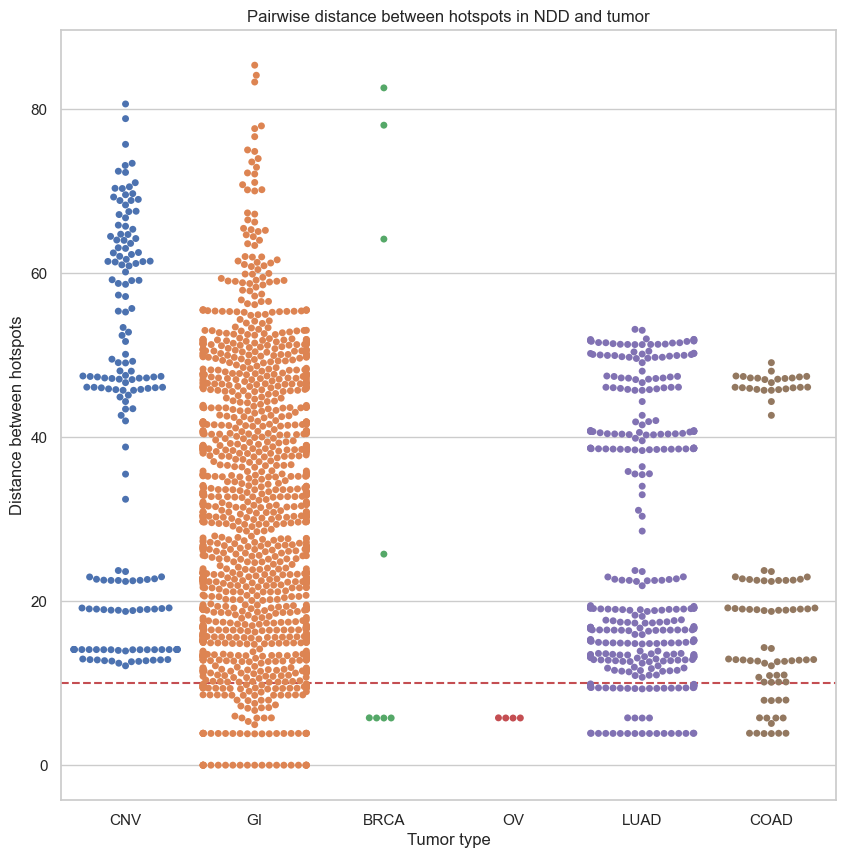

In [93]:
# plot the min max avg distance of protein that are both clustered in NDD and tumor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# combine all distance matrix into one list
all_distance_matrix = {}
for tumor_type in ["CNV", "GI", "BRCA", "OV", "LUAD", "COAD"]:
    df = annotated_hotregions_analysis[tumor_type]
    # get only proteins that are both clustered in N    DD and tumor
    both_clustered = df[(df["NDD_clustered"] == True) & (df["Cancer_clustered"] == True)]
    # get distance matrix and append them all into a list 
    for i in range(len(both_clustered)):
        distance_matrix = both_clustered.iloc[i]["Distance_matrix"]
        # flatten distance matrix
        distance_matrix = distance_matrix.flatten()
        if tumor_type not in all_distance_matrix:
            all_distance_matrix[tumor_type] = list(distance_matrix)
        else:
            all_distance_matrix[tumor_type].extend(list(distance_matrix))

# x axis is tumor type y axis is distance
# create a swarm plot
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel("Distance between hotspots")
ax.set_xlabel("Tumor type")
ax.set_title("Pairwise distance between hotspots in NDD and tumor")
sns.swarmplot(data=all_distance_matrix, ax=ax)
# draw a cutoff line at 10 angstrom
plt.axhline(y=10, color='r', linestyle='--')


### Domain annotation


In [137]:
from Bio import Entrez
import requests

def fetch_ncbi_record(refseq_id):
    Entrez.email = "yilinc5@stanford.edu"
    handle = Entrez.esearch(db="protein", term=refseq_id, retmax=1)
    record = Entrez.read(handle)
    handle.close()

    if record["IdList"]:
        protein_id = record["IdList"][0]
        handle = Entrez.efetch(db="protein", id=protein_id, rettype="gb", retmode="text")
        gb_record = handle.read()
        return gb_record

    return None

In [212]:
import re
def parse_ncbi_data(data):
    annotations = {}
    is_feature_section = False
    current_chunk = []

    for line in data.split('\n'):
        line = line.strip()
        if line.startswith("FEATURES"):
            is_feature_section = True
            continue
        elif line.startswith("ORIGIN"):
            break

        if is_feature_section:
            if line.startswith("Region") or line.startswith("Site"):
                if current_chunk:
                    process_chunk(current_chunk, annotations)
                current_chunk = [line]
            elif line:
                current_chunk.append(line)

    if current_chunk:
        process_chunk(current_chunk, annotations)

    return annotations

import re

def process_chunk(chunk, annotations):
    first_line = chunk[0]
    type_, range_ = first_line.split()[0], first_line.split()[1]
    name, note = "", ""
    current_annotation = None

    # Process each line in the chunk
    for line in chunk:
        if line.startswith("/region_name=") or line.startswith("/site_type="):
            current_annotation = 'name'
            name = line.split('=')[1].strip('"')
        elif line.startswith("/note="):
            current_annotation = 'note'
            note = line.split('=')[1].strip('"')
        elif current_annotation and line.startswith("/"):
            current_annotation = None
        elif current_annotation:
            # Concatenate multi-line annotations
            if current_annotation == 'name':
                name += ' ' + line.strip()
            elif current_annotation == 'note':
                note += ' ' + line.strip()

    # Process the range
    range_ = re.sub(r'[<>]', '', range_)
    if "order(" in range_:
        # add more lines to range until the line that starts with "/"
        for i in range(1, len(chunk)):
            if chunk[i].startswith("/"):
                break
            else:
                range_ += chunk[i]
        # remove "order" and brackets
        range_ = range_.replace("order(", "").replace(")", "")
        # split range into multiple ranges by comma
        ranges = range_.split(",")
        for r in ranges:
            if '..' in r:
                start, end = r.split('..')
                annotations[(int(start), int(end))] = (type_, name, note)
            else:
                annotations[(int(r), int(r))] = (type_, name, note)
    else:
        if '..' in range_:
            start, end = range_.split('..')
            annotations[(int(start), int(end))] = (type_, name, note)
        else:
            annotations[(int(range_), int(range_))] = (type_, name, note)

In [215]:
# get list of all ids in all tumor types that are both clustered
all_ids = []
for tumor_type in ["CNV", "GI", "BRCA", "OV", "LUAD", "COAD"]:
    df = annotated_hotregions_analysis[tumor_type]
    # get only proteins that are both clustered in N    DD and tumor
    both_clustered = df[(df["NDD_clustered"] == True) & (df["Cancer_clustered"] == True)]
    # get distance matrix and append them all into a list 
    for i in range(len(both_clustered)):
        id = both_clustered.iloc[i]["Transcript ID"]
        all_ids.append(id)
# get unique ids
all_ids = list(set(all_ids))

In [221]:
# get all annotations
all_annotations = {}
for id in all_ids:
    # try to fetch ncbi record, if error, try again
    data = None
    while data is None:
        try:
            data = fetch_ncbi_record(id)
        except:
            print("Error fetching", id)
    annotations = parse_ncbi_data(data)
    all_annotations[id] = annotations

Error fetching NP_001257872
Error fetching NP_001123914
Error fetching NP_001123914
Error fetching NP_001365451
Error fetching NP_001317533
Error fetching NP_001361240
Error fetching NP_361014
Error fetching NP_001335148
Error fetching NP_001356496
Error fetching NP_001365477
Error fetching NP_001335180
Error fetching NP_001335180
Error fetching NP_001123493
Error fetching NP_001230156
Error fetching NP_001361242
Error fetching NP_001243750
Error fetching NP_002576
Error fetching NP_001365469
Error fetching NP_001365400


In [250]:
both_clustered_all = {}
for tumor_type in ["CNV", "GI", "BRCA", "OV", "LUAD", "COAD"]:
    print("=====================================")
    print(f"Processing {tumor_type}...")
    df = annotated_hotregions_analysis[tumor_type]
    # get only proteins that are both clustered in N    DD and tumor
    both_clustered = df[(df["NDD_clustered"] == True) & (df["Cancer_clustered"] == True)]
    # add two new columns for annotations
    both_clustered["NDD_hotspot_annotations"] = both_clustered["Transcript ID"].apply(lambda x: {})
    both_clustered["Cancer_hotspot_annotations"] = both_clustered["Transcript ID"].apply(lambda x: {})
    both_clustered["Shared_annotations"] = both_clustered["Transcript ID"].apply(lambda x: {})
    both_clustered["Not_shared_annotations"] = both_clustered["Transcript ID"].apply(lambda x: {})
    # for each id, get the annotations
    for i in range(len(both_clustered)):
        id = both_clustered.iloc[i]["Transcript ID"]
        annotations = all_annotations[id]
        # get hotspots
        hotspots1 = eval(both_clustered.iloc[i]["NDD_hotspots"])
        hotspots2 = eval(both_clustered.iloc[i]["Cancer_hotspots"])

        # get the annotation of each hotspot
        hotspot1_annotation = {}
        hotspot2_annotation = {}
        for hotspot in hotspots1:
            for key in annotations:
                # ignor the "source" annotations
                if annotations[key][0] == "source":
                    continue
                if hotspot in range(key[0], key[1]+1):
                    if hotspot not in hotspot1_annotation:
                        hotspot1_annotation[hotspot] = [annotations[key]]
                    else:
                        hotspot1_annotation[hotspot].append(annotations[key])
            # if no annotation is found, save an empty list
            if hotspot not in hotspot1_annotation:
                hotspot1_annotation[hotspot] = []

        for hotspot in hotspots2:
            for key in annotations:
                if annotations[key][0] == "source":
                    continue
                if hotspot in range(key[0], key[1]+1):
                    if hotspot not in hotspot2_annotation:
                        hotspot2_annotation[hotspot] = [annotations[key]]
                    else:
                        hotspot2_annotation[hotspot].append(annotations[key])
            if hotspot not in hotspot2_annotation:
                hotspot2_annotation[hotspot] = []

        # save annotations in the dataframe
        both_clustered.at[i, "NDD_hotspot_annotations"] = hotspot1_annotation
        both_clustered.at[i, "Cancer_hotspot_annotations"] = hotspot2_annotation

        # compare two annotations, check if any annotations are shared by a hotspot in 1 and another hotspot in 2
        # note that both annotations are dictionaries with hotspot as key and list of annotations as value
        shared_annotations = {}
        not_shared_annotations = {}
        for hotspot1 in hotspots1:
            for hotspot2 in hotspots2:
                # if annotation have one list item in common, save it  ie the intersection of two lists is not empty
                if len(set(hotspot1_annotation[hotspot1]).intersection(set(hotspot2_annotation[hotspot2]))) > 0:
                    shared_annotations[(hotspot1, hotspot2)] = list(set(hotspot1_annotation[hotspot1]).intersection(set(hotspot2_annotation[hotspot2])))
                else:
                    # print the hotspot and annotations that are not shared
                    not_shared_annotations[(hotspot1, hotspot2)] = [hotspot1_annotation[hotspot1], hotspot2_annotation[hotspot2]]
        # save shared annotations in the dataframe
        both_clustered.at[i, "Shared_annotations"] = shared_annotations
        both_clustered.at[i, "Not_shared_annotations"] = not_shared_annotations
        # output id, gene, shared annotations

        print(id, both_clustered.iloc[i]["HUGO Symbol"])

        print("Shared: ", shared_annotations)
        print("Not shared: ", not_shared_annotations)



    print("=====================================")
    print(f"{tumor_type} summary:")
    print("Genes with shared annotations")
    print(*both_clustered[both_clustered["Shared_annotations"] != {}]["HUGO Symbol"].unique(), sep = ", ")
    print("Genes without shared annotations")
    print(*both_clustered[both_clustered["Shared_annotations"] == {}]["HUGO Symbol"].unique(), sep = ", ")
    print("Total number of genes")
    print(len(both_clustered["HUGO Symbol"].unique()))
    print("Number of genes with shared annotations")
    print(len(both_clustered[both_clustered["Shared_annotations"] != {}]["HUGO Symbol"].unique()))
    print("Number of genes without shared annotations")
    print(len(both_clustered[both_clustered["Shared_annotations"] == {}]["HUGO Symbol"].unique()))
    print("=====================================")
    both_clustered_all[tumor_type] = both_clustered
    # write to file
    both_clustered.to_csv(f"/Users/elaine/Documents/HotMAPS2/HM_results_annotated/Both_clustered_NDDvs{tumor_type}_hotregions_annotated.tsv", sep="\t", index=False)

Processing CNV...
NP_001356500 TCF4
Shared:  {}
Not shared:  {(576, 120): [[('Region', 'bHLH_E-protein_TCF4_E2-2', 'basic helix-loop-helix (bHLH) domain found in transcription factor 4 (TCF-4) and similar proteins; cd18945"'), ('Site', 'other', 'putative DNA binding site [nucleotide binding]')], [('Region', 'Disordered.', 'propagated from UniProtKB/Swiss-Prot (P15884.3)')]], (576, 134): [[('Region', 'bHLH_E-protein_TCF4_E2-2', 'basic helix-loop-helix (bHLH) domain found in transcription factor 4 (TCF-4) and similar proteins; cd18945"'), ('Site', 'other', 'putative DNA binding site [nucleotide binding]')], [('Region', 'Disordered.', 'propagated from UniProtKB/Swiss-Prot (P15884.3)')]]}
NP_001230155 TCF4
Shared:  {}
Not shared:  {(682, 222): [[('Region', 'bHLH_E-protein_TCF4_E2-2', 'basic helix-loop-helix (bHLH) domain found in transcription factor 4 (TCF-4) and similar proteins; cd18945"'), ('Site', 'other', 'putative DNA binding site [nucleotide binding]')], []], (682, 236): [[('Region

{(1, 589): ('source',
  '',
  'medium tumor antigen-associated 61 KDA protein; protein phosphatase 2, regulatory subunit A, alpha; testicular secretory protein Li 1"'),
 (2, 2): ('Site', 'acetylation', 'N-acetylalanine.'),
 (8, 399): ('Region',
  'PP2A subunit B binding',
  'propagated from UniProtKB/Swiss-Prot (P30153.4)'),
 (13, 37): ('Region', 'HEAT repeat', 'HEAT repeat [structural motif]'),
 (29, 30): ('Site',
  'other',
  'putative peptide binding site [polypeptide binding]"'),
 (33, 33): ('Site',
  'other',
  'putative peptide binding site [polypeptide binding]"'),
 (36, 37): ('Site',
  'other',
  'putative peptide binding site [polypeptide binding]"'),
 (67, 68): ('Site',
  'other',
  'putative peptide binding site [polypeptide binding]"'),
 (71, 71): ('Site',
  'other',
  'putative peptide binding site [polypeptide binding]"'),
 (74, 75): ('Site',
  'other',
  'putative peptide binding site [polypeptide binding]"'),
 (78, 78): ('Site',
  'other',
  'putative peptide binding si

In [246]:
# check annoations of a protein
id = "NP_001336727"
fbx_annotations = all_annotations[id]
# get annotations of this gene in both clustered
df = both_clustered_all["GI"]
fbx_df = df[df["Transcript ID"] == id]

In [247]:
# check type of record
fbx_df

,Transcript ID,HUGO Symbol,NDD_hotspots,NDD_hotregions,Cancer_hotspots,Cancer_hotregions,Shared_hotspots,NDD_z_score,Cancer_z_score,NDD_clustered,Cancer_clustered,Distance_matrix,"Min, Max, Avg distance",NDD_hotspot_annotations,Cancer_hotspot_annotations,Shared_annotations,Not_shared_annotations
47,NP_001336727,FBXW7,[689],[[689]],"[14, 385, 423, 440, 462, 463, 465, 477, 479, 5...","[[543, 462, 385, 465, 545, 580, 477, 557, 440,...",[689],-1.907077,-2.104228,True,True,"[[26.036527633666992, 12.790092468261719, 15.5...","[0.0, 30.88628387451172, 21.989668941497804]",{},"{14: [('Region', 'Disordered.', 'propagated fr...",{},{}


In [254]:
#NP_001369324
id = "NP_001369324"
sos_annotations = all_annotations[id]
df = both_clustered_all["LUAD"]
sos_df = df[df["Transcript ID"] == id]


In [255]:
sos_df

,Transcript ID,HUGO Symbol,NDD_hotspots,NDD_hotregions,Cancer_hotspots,Cancer_hotregions,Shared_hotspots,NDD_z_score,Cancer_z_score,NDD_clustered,Cancer_clustered,Distance_matrix,"Min, Max, Avg distance",NDD_hotspot_annotations,Cancer_hotspot_annotations,Shared_annotations,Not_shared_annotations
0,NP_001369324,SOS1,[552],[[552]],[233],[],[],-1.834296,-2.047827,True,True,[[21.88224983215332]],"[21.88224983215332, 21.88224983215332, 21.8822...",{552: []},"{233: [('Region', 'RhoGEF', 'Guanine nucleotid...",{},"{(552, 233): [[], [('Region', 'RhoGEF', 'Guani..."


In [258]:
# get a matrix of whether two hotspots have shared annotations
# iterate through all proteins
# for each protein, get the shared annotations
shared_annotation_plot = {}
for tumor_type in ["CNV", "GI", "BRCA", "OV", "LUAD", "COAD"]:
    both_clustered = both_clustered_all[tumor_type]

    shared_annotations_cat = []
    # iterate through each protein
    for i in range(len(both_clustered)):
        # get hotspots
        hotspots1 = eval(both_clustered.iloc[i]["NDD_hotspots"])
        hotspots2 = eval(both_clustered.iloc[i]["Cancer_hotspots"])
        for hotspot1 in hotspots1:
            for hotspot2 in hotspots2:
                # if this pair is in the shared annotations, append "Shared annotations"
                if (hotspot1, hotspot2) in both_clustered.iloc[i]["Shared_annotations"]:
                    shared_annotations_cat.append("Shared annotations")
                else:
                    shared_annotations_cat.append("No shared annotations")
    shared_annotation_plot[tumor_type] = shared_annotations_cat
    

In [265]:
# merge shared_annotation_plot and all_distance_matrix into a dataframe for seaborn swarmplot
# note that all_distance_matrix is a dictionary with tumor type as key and list of distances as value
# shared_annotation_plot is a dictionary with tumor type as key and whether two hotspots have shared annotations as value
# output a dataframe with three columns: tumor type, distance, shared annotations
shared_annotation_plot_df = pd.DataFrame(columns=["Tumor type", "Distance", "Shared annotations"])
for tumor_type in ["CNV", "GI", "BRCA", "OV", "LUAD", "COAD"]:
    shared_annotation_plot_df = pd.concat([shared_annotation_plot_df, pd.DataFrame({"Tumor type": [tumor_type]*len(all_distance_matrix[tumor_type]), "Distance": all_distance_matrix[tumor_type], "Shared annotations": shared_annotation_plot[tumor_type]})], ignore_index=True)



/var/folders/t9/1v5dh1xs26sgvp2lbdy048jw0000gn/T/ipykernel_41076/3039116661.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  shared_annotation_plot_df = pd.concat([shared_annotation_plot_df, pd.DataFrame({"Tumor type": [tumor_type]*len(all_distance_matrix[tumor_type]), "Distance": all_distance_matrix[tumor_type], "Shared annotations": shared_annotation_plot[tumor_type]})], ignore_index=True)


In [268]:
swarm_plot_df = shared_annotation_plot_df
# replace all CNV with CNS
swarm_plot_df["Tumor type"] = swarm_plot_df["Tumor type"].replace("CNV", "CNS")

/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 37.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/elaine/opt/anaconda3/envs/hotmaps2/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


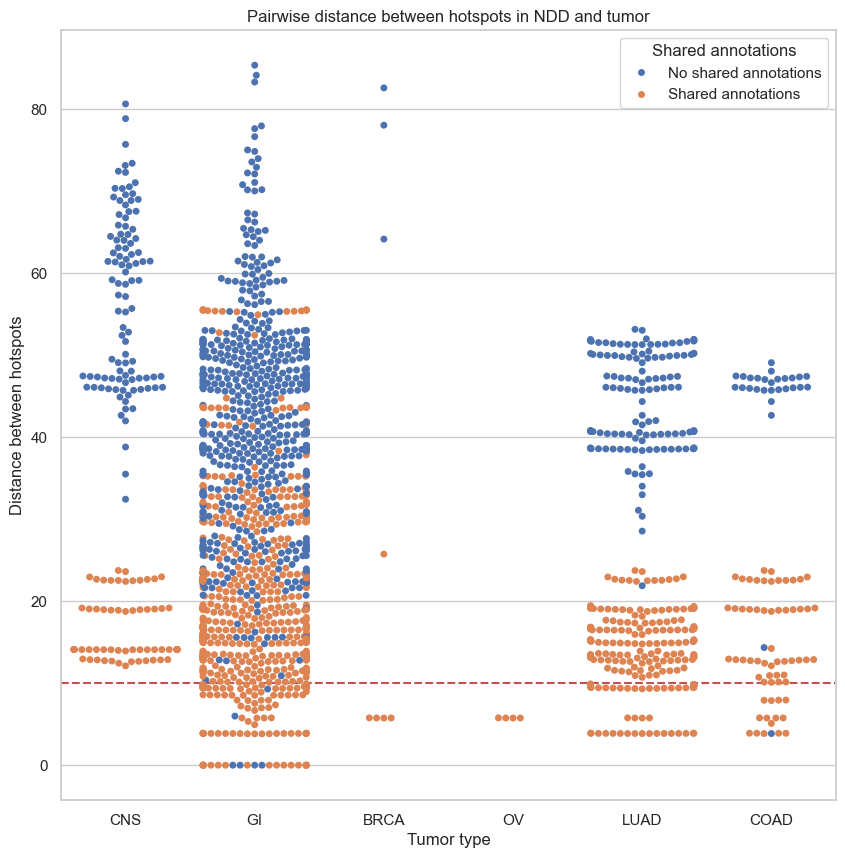

In [269]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel("Distance between hotspots")
ax.set_xlabel("Tumor type")
ax.set_title("Pairwise distance between hotspots in NDD and tumor")
# swarm plot with x as tumor type and y as distance and color as shared annotations
sns.swarmplot(data=swarm_plot_df, x="Tumor type", y="Distance", hue="Shared annotations", ax=ax)
# draw a cutoff line at 10 angstrom
plt.axhline(y=10, color='r', linestyle='--')